## Tully problem 1 

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
from libra_py import models_Tully
from libra_py import tsh
from libra_py import tsh_stat

import matplotlib.pyplot as plt   # plots
import numpy as np
from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<in

In [2]:
xmin = -10.0
xmax = 10.0
dx = 0.01

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in xrange(nsteps):
    X.append(xmin + i * dx)

In [3]:
H00, H11, H01 = [], [], []
dH00, dH11, dH01 = [], [], []
for i in xrange(nsteps):
    q = MATRIX(1,1); q.set(0, 0, X[i])
    obj = models_Tully.Tully1(q, {"A":0.01, "B":1.6, "C":0.005, "D":1.0})
    
    H00.append(obj.ham_dia.get(0,0).real)
    H11.append(obj.ham_dia.get(1,1).real)
    H01.append(obj.ham_dia.get(0,1).real)    
    
    dH00.append(obj.d1ham_dia[0].get(0,0).real)
    dH11.append(obj.d1ham_dia[0].get(1,1).real)
    dH01.append(obj.d1ham_dia[0].get(0,1).real) 

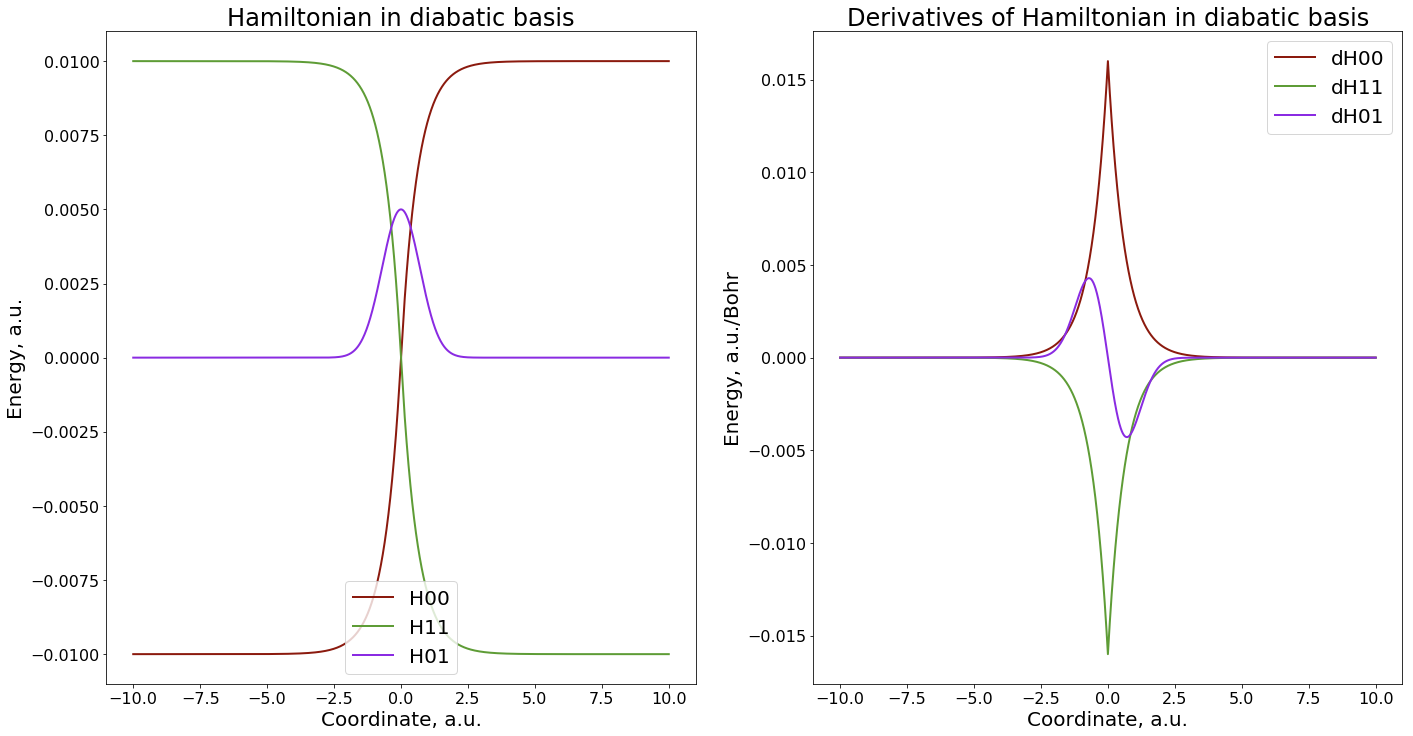

In [4]:
plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Hamiltonian in diabatic basis')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Energy, a.u.')
plt.plot(X, H00, label='H00', linewidth=2, color = colors["11"]) 
plt.plot(X, H11, label='H11', linewidth=2, color = colors["21"]) 
plt.plot(X, H01, label='H01', linewidth=2, color = colors["31"]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('Derivatives of Hamiltonian in diabatic basis')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Energy, a.u./Bohr')
plt.plot(X, dH00, label='dH00', linewidth=2, color = colors["11"]) 
plt.plot(X, dH11, label='dH11', linewidth=2, color = colors["21"]) 
plt.plot(X, dH01, label='dH01', linewidth=2, color = colors["31"]) 
plt.legend()


plt.show()
plt.close()

In [5]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None

    Id = Cpp2Py(full_id)
    indx = Id[-1]

    if model==1:
        res = models_Tully.Tully1(q.col(indx), params)
    elif model==2:
        pass
    elif model==3:
        pass

    #res.rep = params["rep"]    

    return res


In [6]:
def run_test(_q, _p, _Cdia, _Cadi, _iM, model_params, dyn_params, rnd, states):
    """
    model - setup the Hamiltonian
    rep - 0 - diabatic, 1 - adiabatic
    outname - the name of the output file
    """

    obs_T = [] # time
    obs_q = [] # coordinate of the first DOF
    obs_p = [] # momentum of the first DOF
    obs_Ekin = []  # average kinetic energy 
    obs_Epot = []  # average potential energy 
    obs_Etot = []  # average total energy 
    obs_dEkin = []  # kinetic energy fluctuation
    obs_dEpot = []  # potential energy fluctuation
    obs_dEtot = []  # total energy fluctuation
    obs_dm_adi00 = []  # average SE-based population of the state 0 in adiabatic basis
    obs_dm_adi11 = []  # average SE-based population of the state 1 in adiabatic basis
    obs_dm_dia00 = []  # average SE-based population of the state 0 in diabatic basis
    obs_dm_dia11 = []  # average SE-based population of the state 1 in diabatic basis
    obs_pop00 = []  # average SH-based population of the state 0 in diabatic basis
    obs_pop01 = []  # average ??
    obs_ind = []  # ??
    
    
    # Create copies of the input dynamical variables, so we could run several run_test 
    # functions with the same input variables without worries that they will be altered
    # inside of the run_test

    q = MATRIX(_q)
    p = MATRIX(_p)
    iM = MATRIX(_iM)
    Cdia = CMATRIX(_Cdia)
    Cadi = CMATRIX(_Cadi)
    
    rep = dyn_params["rep"]
    dt = dyn_params["dt"]
    nsteps = dyn_params["nsteps"]


    ndia = Cdia.num_of_rows
    nadi = Cadi.num_of_rows
    nnucl= q.num_of_rows
    ntraj= q.num_of_cols

    # ======= Hierarchy of Hamiltonians =======
    ham = nHamiltonian(ndia, nadi, nnucl)
    ham.init_all(2)
    #print "id=", ham.id, " level=", ham.level

    ham1 = [] 
    for tr in xrange(ntraj):
        ham1.append( nHamiltonian(ndia, nadi, nnucl) )        
        ham1[tr].init_all(2)
        ham.add_child(ham1[tr])
        

    # Initial calculations
    ham.compute_diabatic(compute_model, q, model_params, 1)
    ham.compute_adiabatic(1, 1); 
    ham.ampl_adi2dia(Cdia, Cadi, 0, 1)


    if rep==0:
        ham.compute_nac_dia(p, iM, 0, 1);  
        ham.compute_hvib_dia(1); 
    elif rep==1:
        ham.compute_nac_adi(p, iM, 0, 1);
        ham.compute_hvib_adi(1); 


#    sys.exit(0)
    Ekin, Epot, Etot, dEkin, dEpot, dEtot = tsh_stat.compute_etot_tsh(ham, p, Cdia, Cadi, states, iM, rep) 
    #print Ekin, Epot, Etot, dEkin, dEpot, dEtot


    
    # Do the propagation
    for i in xrange(nsteps):

        if rep==0:
            tsh1(dt, q, p, iM,  Cdia, states, ham, compute_model, model_params, dyn_params, rnd)
        elif rep==1:
            tsh1(dt, q, p, iM,  Cadi, states, ham, compute_model, model_params, dyn_params, rnd, 1, 1)

        #=========== Properties ==========
        if rep==0:
            ham.ampl_dia2adi(Cdia, Cadi, 0, 1)
        elif rep==1:
            ham.ampl_adi2dia(Cdia, Cadi, 0, 1)


        dm_dia, dm_adi = tsh_stat.compute_dm(ham, Cdia, Cadi, rep, 1)
        Ekin, Epot, Etot, dEkin, dEpot, dEtot = tsh_stat.compute_etot_tsh(ham, p, Cdia, Cadi, states, iM, rep)
        pops = tsh_stat.compute_sh_statistics(nadi, states)
        #pops = get_probabilities(ham, states)
    

        ind = 0.0
        for tr in xrange(ntraj):
            ind = ind + ham1[tr].get_ordering_adi()[0]
        ind = ind/float(ntraj)
        
        
        obs_T.append(i*dt) 
        obs_q.append(q.get(0))
        obs_p.append(p.get(0))
        obs_Ekin.append(Ekin)
        obs_Epot.append(Epot)
        obs_Etot.append(Etot)
        obs_dEkin.append(dEkin)
        obs_dEpot.append(dEpot)
        obs_dEtot.append(dEtot)
        obs_dm_adi00.append(dm_adi.get(0,0).real)
        obs_dm_adi11.append(dm_adi.get(1,1).real)
        obs_dm_dia00.append(dm_dia.get(0,0).real)
        obs_dm_dia11.append(dm_dia.get(1,1).real)
        obs_pop00.append(pops.get(0,0))
        obs_pop01.append(pops.get(0,1))
        obs_ind.append(ind)
        
    return obs_T, obs_q, obs_p, obs_dm_adi00, obs_dm_adi11, obs_dm_dia00, obs_dm_dia11, obs_pop00, obs_pop01, obs_ind


In [7]:
# Random numbers generator object
rnd = Random()


# Dimensionality and dynamical variables
ndia, nadi, nnucl, ntraj = 2, 2, 1, 25

mean_q = MATRIX(nnucl,1);   mean_q.set(0,0, -2)
sigma_q = MATRIX(nnucl,1);  sigma_q.set(0,0, 0.0)
mean_p = MATRIX(nnucl,1);   mean_p.set(0,0, 20.0)
sigma_p = MATRIX(nnucl,1);  sigma_p.set(0,0, 0.0)

q = MATRIX(nnucl,ntraj);  tsh.sample(q, mean_q, sigma_q, rnd)
p = MATRIX(nnucl,ntraj);  tsh.sample(p, mean_p, sigma_p, rnd)
iM = MATRIX(nnucl,1);     iM.set(0,0, 1.0/2000.0)

istate = 0
Cdia, Cadi = CMATRIX(ndia, ntraj), CMATRIX(nadi, ntraj)
states = intList() 

for traj in xrange(ntraj):
    Cadi.set(istate, traj, 1.0+0.0j);  
    states.append(istate) 


# Model parameters 
model_params = { "model":1, "A":0.01, "B":1.6, "C":0.005, "D":1.0  }

# Dynamics (Simulation) parameters
dyn_params = { "rep":1, "rep_sh":1, "tsh_method":0, "use_boltz_factor":0,
               "nsteps":2000,
               "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":0, "dt":0.5 }

res = run_test(q, p, Cdia, Cadi, iM, model_params, dyn_params, rnd, states)

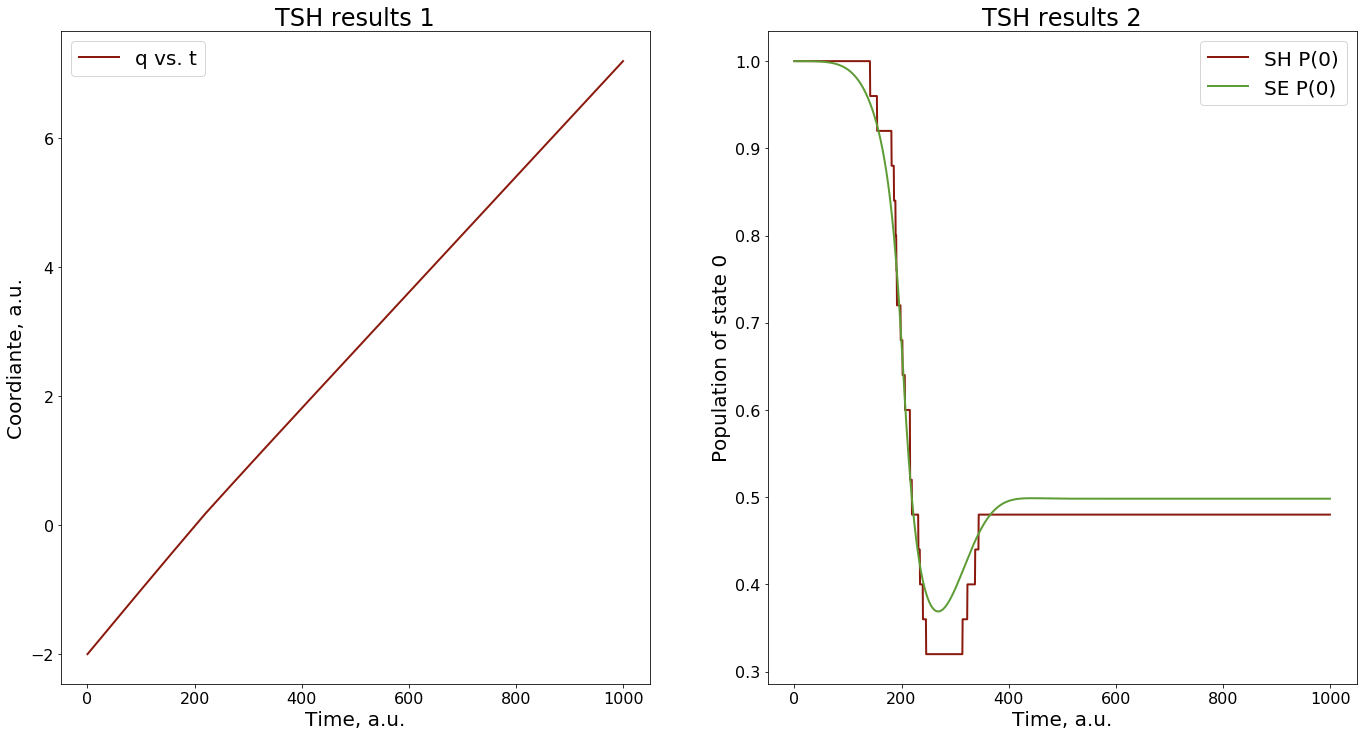

In [8]:
# Format: 
#   0      1      2          3            4             5             6            7          8         9
# obs_T, obs_q, obs_p, obs_dm_adi00, obs_dm_adi11, obs_dm_dia00, obs_dm_dia11, obs_pop00, obs_pop01, obs_ind
obs_T = res[0]
obs_q = res[1] 
obs_pop00 = res[7] 
obs_dm_adi00 = res[3] 


plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('TSH results 1')
plt.xlabel('Time, a.u.')
plt.ylabel('Coordiante, a.u.')
plt.plot(obs_T, obs_q, label='q vs. t', linewidth=2, color = colors["11"]) 
plt.legend()


plt.subplot(1,2,2)
plt.title('TSH results 2')
plt.xlabel('Time, a.u.')
plt.ylabel('Population of state 0')
plt.plot(obs_T, obs_pop00, label='SH P(0)', linewidth=2, color = colors["11"]) 
plt.plot(obs_T, obs_dm_adi00, label='SE P(0)', linewidth=2, color = colors["21"]) 
plt.legend()


plt.show()
plt.close()

In [9]:
def run_scan(p0):
    # Dimensionality and dynamical variables
    ndia, nadi, nnucl, ntraj = 2, 2, 1, 25

    mean_q = MATRIX(nnucl,1);   mean_q.set(0,0, -2)
    sigma_q = MATRIX(nnucl,1);  sigma_q.set(0,0, 0.0)
    mean_p = MATRIX(nnucl,1);   mean_p.set(0,0, p0)
    sigma_p = MATRIX(nnucl,1);  sigma_p.set(0,0, 0.0)

    q = MATRIX(nnucl,ntraj);  tsh.sample(q, mean_q, sigma_q, rnd)
    p = MATRIX(nnucl,ntraj);  tsh.sample(p, mean_p, sigma_p, rnd)
    iM = MATRIX(nnucl,1);     iM.set(0,0, 1.0/2000.0)

    istate = 0
    Cdia, Cadi = CMATRIX(ndia, ntraj), CMATRIX(nadi, ntraj)
    states = intList() 

    for traj in xrange(ntraj):
        Cadi.set(istate, traj, 1.0+0.0j);  
        states.append(istate) 

    # Model parameters 
    model_params = { "model":1, "A":0.01, "B":1.6, "C":0.005, "D":1.0  }

    # Dynamics (Simulation) parameters
    dyn_params = { "rep":1, "rep_sh":1, "tsh_method":0, "use_boltz_factor":0,
                   "nsteps":2000,
                   "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":0, "dt":0.5 }

    res = run_test(q, p, Cdia, Cadi, iM, model_params, dyn_params, rnd, states)
    
    return res

In [10]:
P0 = [10.0, 12.0, 14.0, 16.0, 20.0, 24.0, 30.0, 40.0, 50.0]
T, P = [], []
for p0 in P0:
    res = run_scan(p0)
    T.append(res[1])
    P.append(res[7])

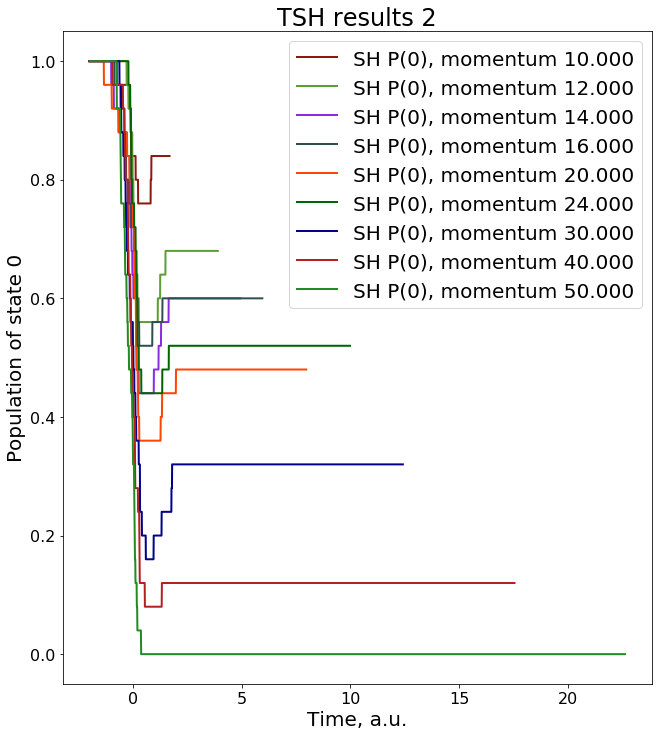

In [11]:
sz = len(T)

plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('TSH results 2')
plt.xlabel('Time, a.u.')
plt.ylabel('Population of state 0')
for i in xrange(sz):
    plt.plot(T[i], P[i], label='SH P(0), momentum %5.3f' % (P0[i]), linewidth=2, color = colors[clrs_index[i]]) 
plt.legend()


plt.show()
plt.close()